### Prediction of Diamond Prices using different models.

##### Using: K-Means, Random Forrest and Linear Regression

In [179]:
# load the libraries
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import  LinearRegression, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt


In [180]:
# load the data.
df = pd.read_csv('diamonds.csv')

In [182]:
# Preview the dataset. 
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


#### Conduct Exploratory Data Analysis

In [185]:
# What is the information?
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB


In [187]:
# What are the basic stats?
df.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


In [189]:
# What are the columns called?
df.columns

Index(['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price', 'x', 'y',
       'z'],
      dtype='object')

In [191]:
# Check for missing/null values.
pd.isna(df).sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

In [193]:
# Clean up datatypes to generate sns heatmap.
df = df.select_dtypes(exclude=[object])

In [195]:
# Create corrleation matrix.
df.corr()

,carat,depth,table,price,x,y,z
carat,1.000000,0.028224,0.181618,0.921591,0.975094,0.951722,0.953387
depth,0.028224,1.000000,-0.295779,-0.010647,-0.025289,-0.029341,0.094924
table,0.181618,-0.295779,1.000000,0.127134,0.195344,0.183760,0.150929
price,0.921591,-0.010647,0.127134,1.000000,0.884435,0.865421,0.861249
x,0.975094,-0.025289,0.195344,0.884435,1.000000,0.974701,0.970772
y,0.951722,-0.029341,0.183760,0.865421,0.974701,1.000000,0.952006
z,0.953387,0.094924,0.150929,0.861249,0.970772,0.952006,1.000000


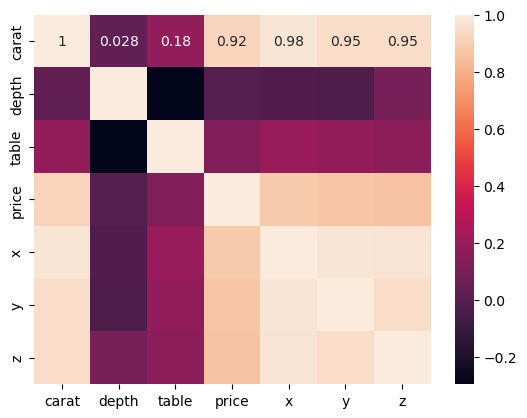

In [197]:
# Create the heatmap.
sns.heatmap(df.corr(),annot=True);

### Preparing the Datasets.

In [200]:
# Determine what to eliminate because high correleations isn't useful in the models.

# Conduct feature engineering (divided x by y columns)
df['symmetry'] = df['x']/df['y']
df.head()

,carat,depth,table,price,x,y,z,symmetry
0,0.23,61.5,55.0,326,3.95,3.98,2.43,0.992462
1,0.21,59.8,61.0,326,3.89,3.84,2.31,1.013021
2,0.23,56.9,65.0,327,4.05,4.07,2.31,0.995086
3,0.29,62.4,58.0,334,4.20,4.23,2.63,0.992908
4,0.31,63.3,58.0,335,4.34,4.35,2.75,0.997701


In [227]:
# Drop any missing values.
df = df.dropna(axis=0)

In [229]:
# Convert categorical variables to numerical entries.
df_trans=pd.get_dummies(df)
X = df_trans.drop(['price','x','y','z'],axis=1)
y=df_trans['price']
features = X.columns

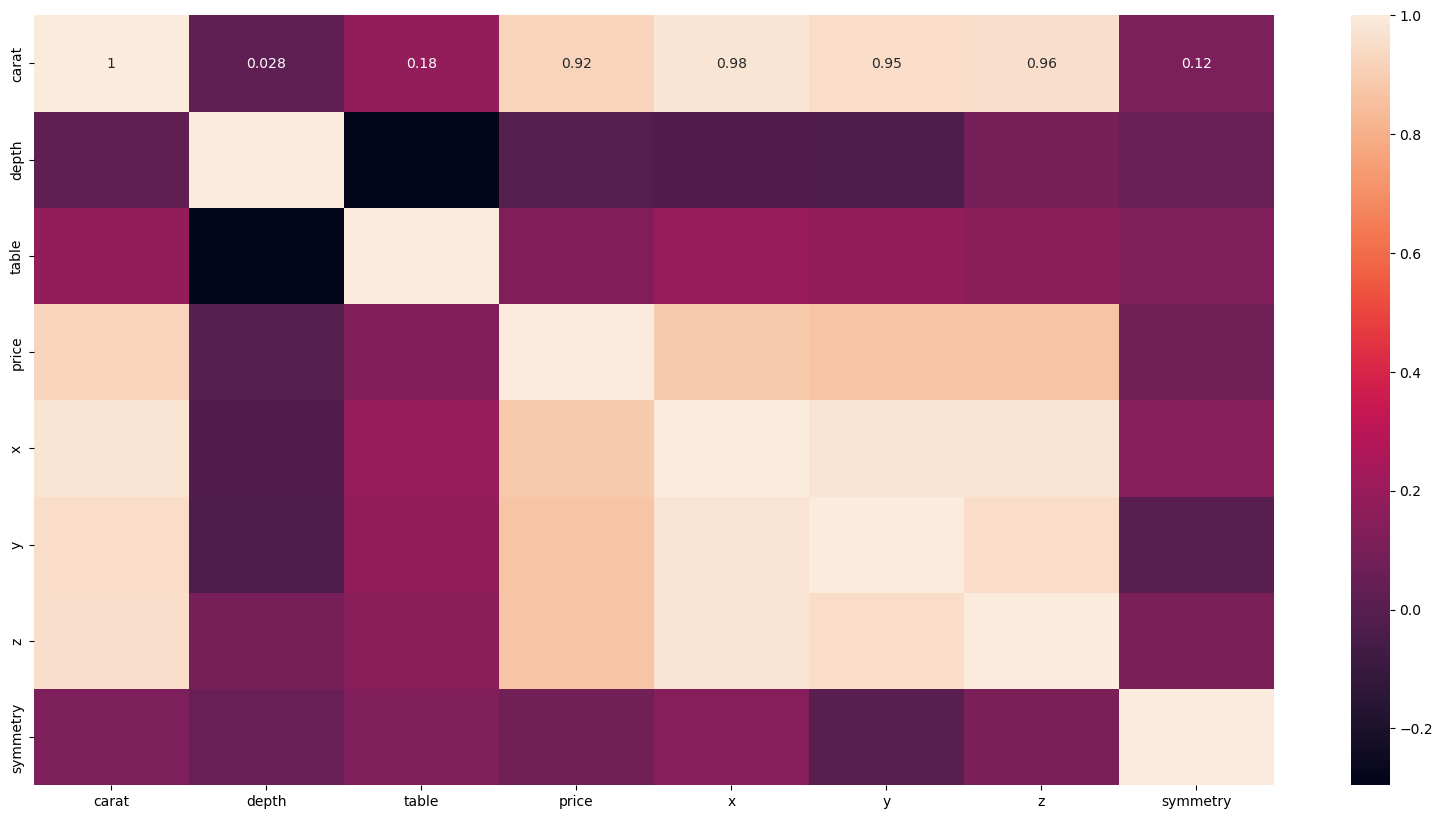

In [230]:
# Create the heatmap. 
plt.figure(figsize=(20,10))
sns.heatmap(df_trans.corr(),annot=True);

In [232]:
# Scale the Data.
s = StandardScaler()

# Fit the data after it has been scaled. 
X = s.fit_transform(X)

In [235]:
# Split the training and testing data.
X_train,X_test,y_train,y_test = train_test_split(X,y)

### Prediction

In [238]:
# Create a df to hold all the results. 
models_eval = pd.DataFrame(index=['Null','KNN','MLR'],columns=['RMSE'])
print(models_eval)

     RMSE
Null  NaN
KNN   NaN
MLR   NaN


In [240]:
# What is the mean for the target variable?
ypred_null = y_train.mean()

#### K-Means Clustering

In [243]:
# Use 7 for nearest neighbours.
knn = KNeighborsRegressor(n_neighbors=7)

In [245]:
# Create the variables. 
knn.fit(X_train,y_train)

KNeighborsRegressor(n_neighbors=7)

In [249]:
# Create the prediction.
y_pred = knn.predict(X_test)

#### Random Forest Regression

In [254]:
# Code the model.
rf = RandomForestRegressor(n_estimators=10)

In [256]:
# Create the variables.
rf.fit(X_train,y_train)

RandomForestRegressor(n_estimators=10)

In [258]:
# Create the prediction.
y_pred2=y_pred = rf.predict(X_test)

#### Linear Regression Model

In [261]:
# Code the model.
lin = LinearRegression()

In [263]:
# Create the variables.
lin = lin.fit(X_train,y_train)

In [265]:
# Create the prediction.
y_pred3 = lin.predict(X_test)

#### Lasso Regression for desensitzation.

In [270]:
# Build the model. 
lasso = Lasso()

In [272]:
# Create the variables.
lasso.fit(X_train,y_train)

Lasso()

In [274]:
# Create the prediction. 
y_pred4 = lasso.predict(X_test)

#### Calculate the Errors and Usefulness of Models

In [278]:
model_eval=pd.DataFrame(index=['KNN','MLR'],columns=['RMSE'])
model_eval.loc['KNN','RMSE']=np.sqrt(mean_squared_error(y_test,y_pred))
model_eval.loc['RF','RMSE'] = np.sqrt(mean_squared_error(y_test,y_pred2))
model_eval.loc['MLR','RMSE'] = np.sqrt(mean_squared_error(y_test,y_pred3))
model_eval.loc['Lasso','RMSE'] = np.sqrt(mean_squared_error(y_test,y_pred4))
model_eval.loc['NULL','RMSE'] = ypred_null
model_eval

,RMSE
KNN,1452.555786
MLR,1494.833506
RF,1452.555786
Lasso,1494.792199
NULL,3935.54078


In [280]:
### The models have very similar results.

#### Visualise the Datasets.

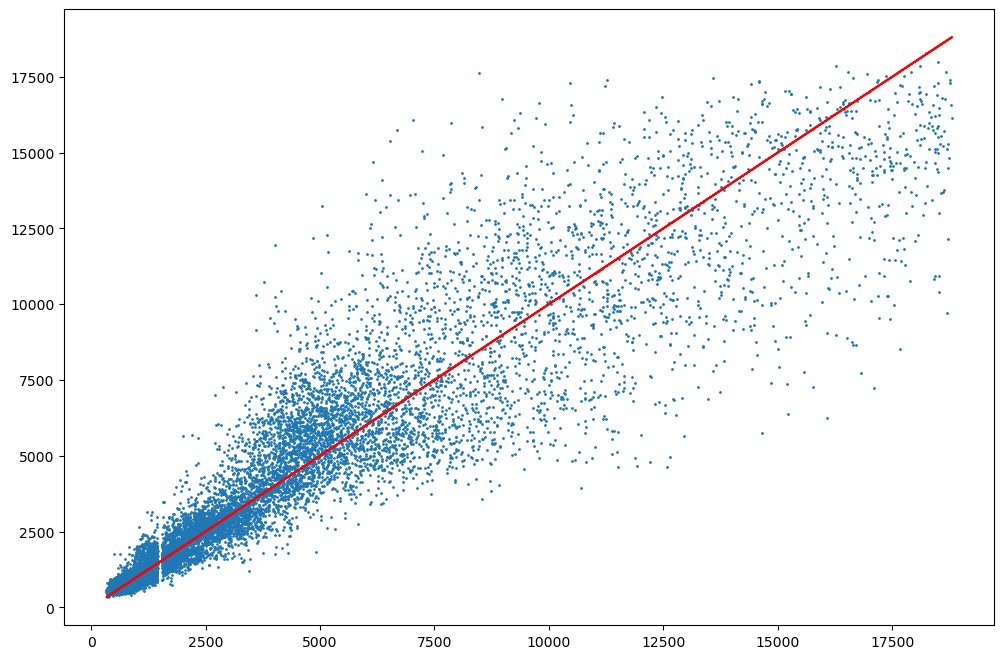

In [285]:
# Create a scatterplot.
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(y_test,y_pred,s=1)
ax.plot(y_test,y_test,color='red')

/tmp/ipykernel_194/1918118665.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred-y_test)
/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='price', ylabel='Density'>

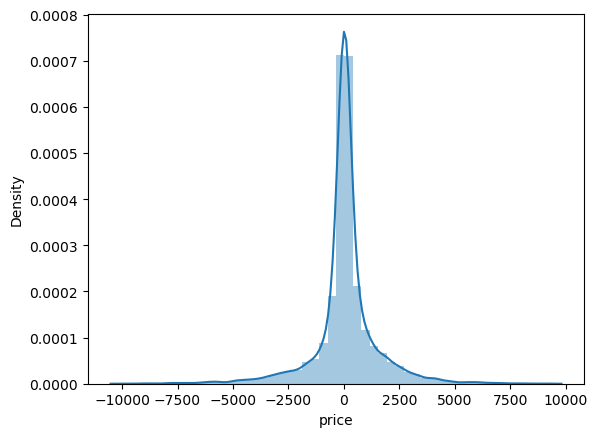

In [287]:
# What is the distribution?
sns.distplot(y_pred-y_test)

In [289]:
# What are the errors?
lin=LinearRegression()
lin.fit(X_train,y_train)
y_pred2 = lin.predict(X_test)
model_eval.loc['MLR','RMSE']=np.sqrt(mean_squared_error(y_pred2,y_test))

In [291]:
#features importance
from sklearn.ensemble import ExtraTreesRegressor
model =ExtraTreesRegressor()
model.fit(X,y)

ExtraTreesRegressor()

In [292]:
model.feature_importances_.tolist()

[0.8907793750918727,
 0.043375338851967316,
 0.020053344430189135,
 0.04579194162597078]